# Simple example of a recurrent SLDS

In [1]:
import os
import pickle

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

from ssm.models import SLDS
from ssm.util import random_rotation

In [2]:
# Global parameters
T = 1000
K = 4
D_obs = 10
D_latent = 2

In [3]:
# Simulate the "nascar" data
def make_nascar_model():
    As = [random_rotation(D_latent, np.pi/24.),
      random_rotation(D_latent, np.pi/48.)]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))
    
    # emission model
    C = npr.randn(1, D_obs, D_latent)
    d = np.zeros((1, D_obs))

    true_rslds = SLDS(D_obs, K, D_latent, 
                      observations="gaussian",
                      single_subspace=True,
                      recurrent_only=True)
    true_rslds.mu_init = np.array([0, 1])
    true_rslds.inv_sigma_init = np.log(1e-4) * np.ones(2)
    true_rslds.As = np.array(As)
    true_rslds.bs = np.array(bs)
    true_rslds.inv_sigmas = np.log(1e-4) * np.ones((K, D_latent))
    true_rslds.Rs = Rs
    true_rslds.r = r
    true_rslds.Cs = C
    true_rslds.ds = d
    true_rslds.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    return true_rslds

# Sample from the model
true_rslds = make_nascar_model()
z, x, y = true_rslds.sample(T=T)

In [4]:
# Fit a robust rSLDS with its default initialization
rslds = SLDS(D_obs, K, D_latent, 
             observations="gaussian",
             single_subspace=True,
             robust_dynamics=True,
             recurrent_only=True)
elbos, (xhat, xvar) = rslds.fit(y, num_iters=2000, print_intvl=100)
zhat = rslds.most_likely_states(xhat)

Initializing with an ARHMM fit via  25  iterations of EM.
Done.

Iteration 0.  ELBO: 6406.014593606799
Iteration 100.  ELBO: 6887.378305035666
Iteration 200.  ELBO: 7155.909559221089
Iteration 300.  ELBO: 7186.304720422585
Iteration 400.  ELBO: 7256.690559568466
Iteration 500.  ELBO: 7251.424351342177
Iteration 600.  ELBO: 7320.58437892921
Iteration 700.  ELBO: 7333.388065561013
Iteration 800.  ELBO: 7410.534466303338
Iteration 900.  ELBO: 7427.4762251232805
Iteration 1000.  ELBO: 7458.948310963413
Iteration 1100.  ELBO: 7478.987504223201
Iteration 1200.  ELBO: 7465.6077934459745
Iteration 1300.  ELBO: 7524.098504385864
Iteration 1400.  ELBO: 7540.303410706329
Iteration 1500.  ELBO: 7610.13225917989
Iteration 1600.  ELBO: 7677.279028282774
Iteration 1700.  ELBO: 7631.939471613871
Iteration 1800.  ELBO: 7637.549930832669
Iteration 1900.  ELBO: 7624.032038747444


Text(0,0.5,'ELBO')

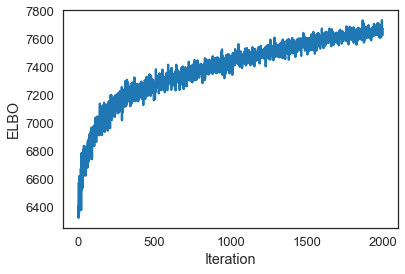

In [5]:
# Plot some results
plt.figure()
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [6]:
# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)

    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.Rs.T) + model.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.As, model.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

Text(0.5,1,'Inferred')

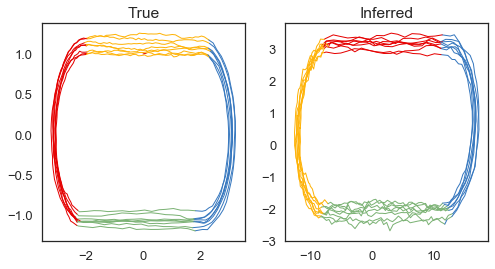

In [7]:
plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
plot_trajectory(z, x, ax=ax1)
plt.title("True")
ax2 = plt.subplot(122)
plot_trajectory(zhat, xhat, ax=ax2)
plt.title("Inferred")

Text(0.5,1,'Inferred Dynamics')

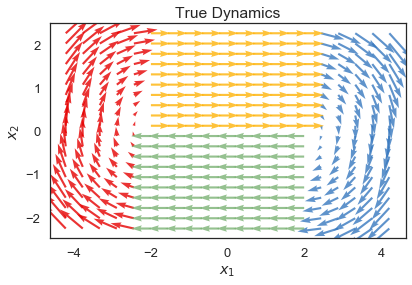

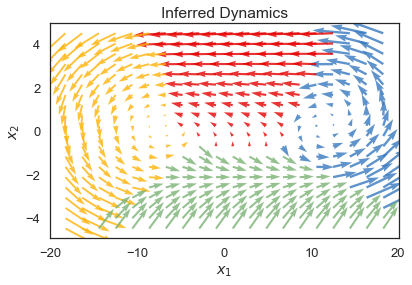

In [8]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(x).max(axis=0) + 1
plot_most_likely_dynamics(true_rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("True Dynamics")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics")